In [56]:
import pandas as pd

print("hi")

hi


## dataset.py

In [72]:
import torchio as tio
# from data_prep import * # comment back in when in its own module

from sklearn.model_selection import train_test_split


class TorchDataHandler():

    """
    This class handles the full dataset creation, preparing all of the files 
    and then creating the subjects dataset. 

    """

    def __init__(self, dataset_params): 

        self.data_preparer = TorchDataPrep(dataset_params['root_dir'],
                                      dataset_params['data_dir'],
                                      dataset_params['txt_files'],
                                      dataset_params['data_dict'])

        self.regex_dict = dataset_params['regex_dict']
        self.classes = dataset_params['classes']

        # Dictionary to store artifacts of processing 
        self.data_preparation_artifacts = {}

    def prepare_data(self):

        final_df = self.data_preparer.process_dataframes()
        self.data_preparation_artifacts['final_df'] = final_df 

        file_dict = self.data_preparer.pair_subject_files(**self.regex_dict)
        
        # TODO: Add checks for file dict here before using 
        self.data_preparer.data_dict['file_dict'] = file_dict 

        self.data_preparation_artifacts['file_dict'] = file_dict

        subjects = self.data_preparer.get_subject_list()
        self.data_preparation_artifacts['subjects'] = subjects 
    
        return subjects 

    def create_dataset(self, train_transforms, 
                             val_transforms, 
                             test_size=0.2):

        """
        Arguments:
        labels: (list), can include 'CONTROL', 'SCHZ', 'BIPOLAR', 'ADHD'
        subjects: (list), list of all subjects in the dataset
        train_transforms: transforms for training set
        val_transforms: transforms for validation set
        """
        
        subjects = self.data_preparation_artifacts['subjects']
        labels = self.classes 
        mapping = {l: i for i, l in enumerate(labels)}

        filtered_subjects = [subject for subject in subjects if subject.diagnosis in labels]
        # filtered_subjects = [subject.diagnosis = (subject.diagnosis, mapping[subject.diagnosis]) for subject in subjects]


        # num_subjects = len(filtered_subjects)
        filtered_labels = [mapping[subject.diagnosis] for subject in filtered_subjects]

        # import pdb; pdb.set_trace()
        training_subjects, validation_subjects, _, _ = train_test_split(filtered_subjects, filtered_labels, test_size=test_size, 
                                                                  stratify=filtered_labels, random_state=42)

        print(training_subjects[0].diagnosis)
        training_set = tio.SubjectsDataset(training_subjects, transform=train_transforms)
        validation_set = tio.SubjectsDataset(validation_subjects, transform=val_transforms)
        print(training_set[0].diagnosis)

        return training_set, validation_set




## data_prep.py

In [220]:
import glob 
import shutil 
import re
import os

import numpy as np
import pandas as pd
import torchio as tio
import dicom2nifti


from tqdm import tqdm 

class TorchDataPrep():
    
    """
    This class handles the data preparation of the files and 
    creates the necessary files that can then be passed to the 
    TorchDataset 
    
    """
    
    def __init__(self, 
                 root_dir : str, 
                 data_dir : str,
                 txt_files : list, 
                 data_dict : dict
                 ):
        
        """
        Args: 
            root_dir: Path to the root directory of the dataset 
            data_dir: Path to the directory which contains all 
                      of the imaging files
            txt_files: List of text files that are relevant data 
            data_dict: Contains relevant columns that indicate important 
                       subject-related or symptom-related information and 
                       can be used to combine multiple files 
                       
                       {
                           subject_cols: {age: [], 
                                          id: []},
                           phenotype_cols: [],
                           join_cols: [],
                           file_dict: {subject1: file1,
                                       subject2: file2,
                                       etc}
                       }
        """
        
        self.root_dir = os.path.abspath(root_dir) 
        self.data_dir = os.path.abspath(data_dir) 
        self.txt_files = txt_files
        self.data_dict = data_dict
        
        self.df_list = self.load_txt_files()
        
        self.final_df = None 

    def load_txt_files(self):
        
        """
        Load all text files and load into list of dataframes 
        Args: 
            None 
        """
        
        df_list = []
        
        for file in self.txt_files:
            file = os.path.join(self.root_dir, file)
            df = pd.read_csv(file, delimiter = "\t")
            
            #  TODO: Figure out a way of getting rid of annoying first row    
            print(df.loc[0][1], df.columns[1])
            if df.loc[0][1] == df.columns[1]:
                df = df.drop([0])
                
            df_list.append(df) 
                
        return df_list
            
    def process_dataframes(self):
        
        """
        Process dataframes:
            1. Join all of them 
            2. Keep important columns 
            3. Drop duplicates
        Args: 
            df - dataframe to be loaded as the final df 
        """   

        if len(self.df_list) > 1:
            final_df = reduce(lambda left,right: pd.merge(left,right,on=self.data_dict['join_cols']), 
                              self.df_list)
        else:
            final_df = self.df_list[0]

        l = list(self.data_dict['subject_cols'].values()) \
            + list(self.data_dict['phenotype_cols'].values())
        l = filter(None, l)
                   
        final_df = final_df[l]
        final_df = final_df.drop_duplicates()
        self.final_df = final_df 
        return final_df 
    
    def load_df(self, df):
            
        """
        Allows user to feed the finalized df for subjects processing 
        Args: 
            df - dataframe to be loaded as the final df 
        """                
        self.final_df = df 

    
    def pair_subject_files(self, subject_regex=None, file_regex=None, file_extension=None):
        
        """
        Create dictionary between subjects and files 
        Args: 
            subject_regex: Regex to obtain specific user information 
            file_regex: Regex to match specific files 
            file_extension: [tgz, nii.tgz] 
        """
        
        subject_files = {}

        if self.data_dict['file_dict'] is None: 
            
            assert subject_regex is not None
            assert file_regex is not None
            assert file_extension is not None
            
            """ Try one specific method -- user can use this for blueprint code for their data """
            for dir in tqdm(os.listdir(self.data_dir)):
                subject = re.search('{}'.format(subject_regex), dir)
                if subject:
                    subject = subject.group(1)
                    
                    files = glob.glob(os.path.join(self.data_dir, dir, '**', '*.{}' \
                                                   .format(file_extension)), 
                                     recursive=True)
                    files = [f for f in files if re.search(file_regex, f)]
                    subject_files[subject] = files
                else:
                    print("Error: can't find subject using regex for {}".format(dir))
                
                
            if file_extension == "tgz":
                for subject in tqdm(subject_files.keys()):
                    list_files = []
                    for file in subject_files[subject]:
                        print(subject, file)
                        if os.path.isdir(file[:-4]):    
                            pass 
                        else:
                            shutil.unpack_archive(file, file[:-4])
                        list_files.append(file[:-4]) # map subject to dicom folder
                    subject_files[subject] = list_files
        else:
            subject_files = self.data_dict['file_dict']
              
        if self.data_dict['dicom2nifti']:
            for subject, files in subject_files.items():
                list_files = []
                for file in files:
                    assert os.path.isdir(file)
                    new_file_name = file + '_converted.nii'
                    dicom2nifti.dicom_series_to_nifti(file, new_file_name, reorient_nifti=True)
                    list_files.append(new_file_name)
                subject_files[subject] = list_files

        if self.data_dict['deface']:
            for subject, files in subject_files.items():
                list_files = []
                for file in files:
                    curr_file_name, curr_file_extension = os.path.splitext(file)
                    assert curr_file_extension == '.nii' # not sure if file needs to be nii or if nii.gz also works
                    os.system('pydeface ' + file)
                    list_files.append(curr_file_name + "_defaced.nii")
                subject_files[subject] = list_files
        

        # print('subject_files: {}'.format(subject_files)) # take out

        return subject_files        
                            
    def get_subject_list(self, use_nda=True):
        subjects = []

        for idx, row in  tqdm(self.final_df.iterrows(), total=self.final_df.shape[0]):

            participant_id = row[self.data_dict['subject_cols']['id']]
                
            diagnosis = row[self.data_dict['phenotype_cols']['phenotype']]
            
            if 'age' in self.data_dict['subject_cols'].keys():
                age = row[self.data_dict['subject_cols']['age']]
            else: 
                age = None 
                
            try: 
                
                # TODO: CHECK IT - THIS SEEMS WRONG (just choose the first one) 
                if len(self.data_dict['file_dict'][participant_id]) > 1:
                    self.data_dict['file_dict'][participant_id] = self.data_dict['file_dict'][participant_id][0] 
                
                if age:
                    # print(self.data_dict['file_dict'][participant_id]) # take out
                    subj = tio.Subject(
                        t1 = tio.ScalarImage(self.data_dict['file_dict'][participant_id]),                   name=participant_id,
                        age = age,
                        diagnosis=diagnosis
                    )
                else:
                    subj = tio.Subject(
                        t1 = tio.ScalarImage(self.data_dict['file_dict'][participant_id]),                   name=participant_id,
                        diagnosis=diagnosis
                    )
                
                subjects.append(subj)
            except Exception: 
                print('Could not find file for id: {}! Skipping!'.format(participant_id))
        print('Finished!')
        return subjects

In [217]:
# load in csv
master_table = pd.read_csv('./FINAL/master_table.csv', sep = '\t')
master_table.head()

,collection_id_x,image03_id,dataset_id_x,subjectkey_x,src_subject_id,interview_age,sex_x,comments_misc,image_file,image_description,...,gps_g7,gps_g8,gps_g9,gps_g10,gps_g11,gps_g12,gps_g13,gps_g14,gps_g15,gps_g16
0,2274,455311,11148,NDAR_INVENJK68TH,3494,324,F,ORIGINALPRIMARYMND,../physcosis/Package_1187332/image03/FINAL/S74...,T1 MPRAGE,...,1,1,1,3,1,1,1,1,1,1
1,2274,455312,11148,NDAR_INVR1X1BJXH,3080,552,F,ORIGINALPRIMARYMND,../physcosis/Package_1187332/image03/FINAL/S82...,T1 MPRAGE,...,3,1,1,1,1,4,1,1,1,3
2,2274,455314,11148,NDAR_INVET1RDAWC,2749,600,F,ORIGINALPRIMARYMND,../physcosis/Package_1187332/image03/FINAL/S55...,T1 MPRAGE,...,1,2,1,2,1,2,4,1,1,5
3,2274,455316,11148,NDAR_INV0647UAN8,3034,288,F,ORIGINALPRIMARYMND,../physcosis/Package_1187332/image03/FINAL/S95...,T1 MPRAGE,...,1,6,1,2,4,3,2,3,1,1
4,2274,455319,11148,NDAR_INVJ7GBZ7ND,3094,396,M,ORIGINALPRIMARYMND,../physcosis/Package_1187332/image03/FINAL/S55...,T1 MPRAGE,...,3,1,4,3,2,6,3,3,3,4


In [223]:
# create file_dict from csv
file_dict = {}
for i,row in master_table.iterrows():
    # file_dict should be dictionary mapping (id -> list of image file paths for subject)
    file_dict[row['src_subject_id']] = [row['image_file'][-30:]] # change substring based on local path

print(len(file_dict))

# load in yaml config file
with open('nda_2274.yaml') as f:
    config = yaml.safe_load(f)

# set file_dict config to be file_dict we created
config['dataset_params']['data_dict']['file_dict'] = file_dict

# create data_handler and subjects
data_handler = TorchDataHandler(config['dataset_params'])
subjects = data_handler.prepare_data() 

100%|██████████| 291/291 [00:00<00:00, 2605.14it/s]291
455311 image03_id
Could not find file for id: 3494! Skipping!
Could not find file for id: 3080! Skipping!
Could not find file for id: 2749! Skipping!
Could not find file for id: 3034! Skipping!
Could not find file for id: 3094! Skipping!
Could not find file for id: 3743! Skipping!
Could not find file for id: 2236! Skipping!
Could not find file for id: 2584! Skipping!
Could not find file for id: 2667! Skipping!
Could not find file for id: 2002! Skipping!
Could not find file for id: 2940! Skipping!
Could not find file for id: 2425! Skipping!
Could not find file for id: 2435! Skipping!
Could not find file for id: 2523! Skipping!
Could not find file for id: 2301! Skipping!
Could not find file for id: 3863! Skipping!
Could not find file for id: 3758! Skipping!
Could not find file for id: 3265! Skipping!
Could not find file for id: 2739! Skipping!
Could not find file for id: 2531! Skipping!
Could not find file for id: 3670! Skipping!
Cou

113
ScalarImage(path: "[WindowsPath('FINAL/S2470JXQ-1-2_defaced.nii')]"; type: intensity)


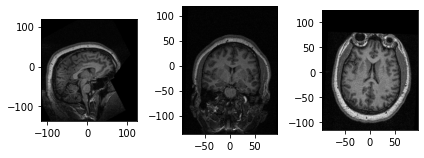

In [224]:
print(len(subjects))
print(subjects[10].t1)
subjects[10].t1.plot()